# U-net Denoising demo

Notebook containing all work relevant to creating a neural network based denoising pipeline. The notebook contains each of the following steps:

1. Load the data
    1. Load in sources of clean PCGs (Pascal, Physionet 2016)
    2. Load in sources of relevant real-world noises (ESC-50, ARCA-23K, HAN)
2. Normalization steps for the data + build a toolkit for the rest of the notebook
    1. Filtering, zero-mean, match signal lengths, [-1,1] normalization, resample, combine two signals at a SNR, ...
3. Combine the signals and noises to make pairs of noisy-clean PCGs
    1. Do visualizations and other qualitative analyses
4. (Legacy) Create STFT features from those recordings 
5. Create train/val/test splits
6. Model Design
7. Model Training
8. Results Analysis
9. Appendix

## 0. Introduction
This section is for importing libraries and defining paths

### 0.a - Cloud Training
Set the below boolean to true if the code is being run on Rice's cloud clusters

In [1]:
on_cloud = False # !impt

### 0.b - Imports

In [ ]:
# import libraries
from scipy import signal
from time import time
from copy import deepcopy
from IPython.display import Audio
from sklearn.utils import shuffle
from math import ceil
from heart_utils import *

import random
import librosa
import numpy as np
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# reproducibility
seed = 777 # three lucky numbers
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)
# this should take care of reproducibility in sklearn too
# (see https://sklearn-genetic-opt.readthedocs.io/en/stable/tutorials/reproducibility.html)

# if training on cloud
if on_cloud: # !impt (only if you're on Rice's clusters): set these. Run nvidia-smi and top first, also check spreadsheet
  device_str = '1' # should change often
  threads_str = '2' # shouldn't
  os.environ['CUDA_VISIBLE_DEVICES'] = device_str
  os.environ['OMP_NUM_THREADS'] = threads_str
  os.environ['CUBLAS_WORKSPACE_CONFIG']=":4096:8"

In [3]:
# check reproducibility (run these many times, after running all)
# if randomness is reproducible, the below code should give the same results every time
### Code
#print(get_random_noise_path(),shuffle([1,2,3,4,5], [-1,-2,-3,-4,-5], random_state = seed))
#tr,va,te = torch.utils.data.random_split(dataset,[.7,.15,.15],generator=gen)
#for (inpt,outpt) in make_batch(tr,32):
#  print(inpt,outpt)
#  break
### End Code
# reproducibility is the case for everything it seems (torch, python random, np random, sklearn)

### 0.c - Paths

In [4]:
# for cloud compute vs local running
if torch.cuda.is_available(): # i.e. if not running on my macbook
  # !impt: ^ the assumption is that the non-cloud device doesn't have cuda (this is the case for me)
  prepend = '/mnt/data1/emz1/heart/datasets/'
  split_dir = '/mnt/data1/emz1/heart/splits/'
  model_dir = '/mnt/data1/emz1/heart/models/'

else:
  prepend = '/Users/donu/Desktop/semesters/S25/ELEC 594/datasets/'
  split_dir = '/Users/donu/Desktop/semesters/S25/ELEC 594/storage/'
  model_dir = '/Users/donu/Desktop/semesters/S25/ELEC 594/storage/' # not a typo

prepend

'/Users/donu/Desktop/semesters/S25/ELEC 594/datasets/'

In [5]:
## Dirs
# physio22/circor dataset
physio22_path = prepend+'physio22/'
# the bentley dataset is the clean PCG dataset from the U-net paper
pascal_dset_path = prepend+'pascal-dset/'

In [6]:
arcalabels_path = prepend+'ARCA23K_ground_truth/'
# the arcawavs directory contains the real world noise data from the ARCA23K dataset
arcawavs_path = prepend+'ARCA23K_audio/'
# hospital ambient sounds dataset, from the Ali paper
han_raw_path = prepend+'hospital-noise-original/'
han_filtered_path = prepend+'hospital-noise-filtered-resampled/'

In [7]:
# OAHS/physionet '16
physio16_path = prepend+'physio16/'
physio_anno_path = physio16_path +'annotations/Online_Appendix_training_set.csv'

In [8]:
# ESC50 dataset
esc50_path = prepend+'ESC-50/'
esc50_anno_path = esc50_path + 'meta/esc50.csv'

## 1. Loading the data

### 1.a Exploring PCG data

In [9]:
# Exploring the PCG data
pcg_data = pd.read_csv(physio22_path+'training_data.csv')

In [10]:
pcg_data.shape

(942, 23)

In [11]:
pcg_data.columns

Index(['Patient ID', 'Recording locations', 'Age', 'Sex', 'Height', 'Weight',
       'Pregnancy status', 'Murmur', 'Murmur locations',
       'Most audible location', 'Systolic murmur timing',
       'Systolic murmur shape', 'Systolic murmur grading',
       'Systolic murmur pitch', 'Systolic murmur quality',
       'Diastolic murmur timing', 'Diastolic murmur shape',
       'Diastolic murmur grading', 'Diastolic murmur pitch',
       'Diastolic murmur quality', 'Outcome', 'Campaign', 'Additional ID'],
      dtype='object')

In [12]:
pcg_data['Murmur'].value_counts()

Murmur
Absent     695
Present    179
Unknown     68
Name: count, dtype: int64

In [13]:
pcg_data.loc[pcg_data['Murmur'].eq('Absent') | pcg_data['Murmur'].eq('Present')].head()

,Patient ID,Recording locations,Age,Sex,Height,Weight,Pregnancy status,Murmur,Murmur locations,Most audible location,...,Systolic murmur pitch,Systolic murmur quality,Diastolic murmur timing,Diastolic murmur shape,Diastolic murmur grading,Diastolic murmur pitch,Diastolic murmur quality,Outcome,Campaign,Additional ID
0,2530,AV+PV+TV+MV,Child,Female,98.0,15.9,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
1,9979,AV+PV+TV+MV,Child,Female,103.0,13.1,False,Present,AV+MV+PV+TV,TV,...,High,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
3,13918,AV+PV+TV+MV,Child,Male,98.0,15.9,False,Present,TV,TV,...,Low,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
4,14241,AV+PV+TV+MV,Child,Male,87.0,11.2,False,Present,AV+MV+PV+TV,PV,...,Low,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
5,14998,AV+PV+TV+MV,Child,Male,NaN,NaN,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN


### 1.b Loading the PASCAL dataset

In [14]:
pcg_data = pd.read_csv(pascal_dset_path+'set_b.csv')

In [15]:
pcg_data['label'].value_counts()

label
normal        320
murmur         95
extrastole     46
Name: count, dtype: int64

### 1.b.1 - Clean up horrible data formatting

In [16]:
#for i in range(pcg_data.shape[0]):
##  # delete "Btraining"
##  #pcg_data.loc[i,'fname'] = 'setb/'+pcg_data.iloc[i,:]['fname'].split('/')[-1][10:]
#  filename = pcg_data.iloc[i,:]['fname'].split('/')[-1]
#  cut_idx = re.search(r'\d',filename).start()
#  pcg_data.loc[i,'fname'] = pcg_data.loc[i,'fname'].replace('setb','set_b')
#  pcg_data.loc[i,'fname'] = 'set_b/'+filename[cut_idx:]
#  

In [17]:
#pcg_data.to_csv(pascal_dset_path+'set_b.csv',index=False)

In [18]:
pcg_data['sublabel'].value_counts()

sublabel
noisynormal    120
noisymurmur     29
Name: count, dtype: int64

In [19]:
pcg_data = pcg_data.loc[(pcg_data['label'].eq('normal') |
                        pcg_data['label'].eq('murmur')) & 
                        pcg_data['sublabel'].ne('noisynormal') & 
                        pcg_data['sublabel'].ne('noisymurmur')]

In [20]:
pcg_data

,dataset,fname,label,sublabel
46,b,set_b/112_1306243000964_A.wav,murmur,NaN
47,b,set_b/112_1306243000964_B.wav,murmur,NaN
48,b,set_b/112_1306243000964_D.wav,murmur,NaN
49,b,set_b/116_1306258689913_A.wav,murmur,NaN
50,b,set_b/116_1306258689913_C.wav,murmur,NaN
...,...,...,...,...
307,b,set_b/296_1311682952647_A1.wav,normal,NaN
308,b,set_b/296_1311682952647_A2.wav,normal,NaN
309,b,set_b/298_1311685888900_B.wav,normal,NaN
310,b,set_b/299_1311770522820_C.wav,normal,NaN


In [21]:
pcg_data.shape # this does not contain noisy data
# it does not contain murmurs either. this may be hugely importnat
# !IMPT: does not contain unlabelled data (which is like 1/3rd of dataset)

(266, 4)

In [22]:
# write to csv
##pcg_data.to_csv(bentley_dset+'set_b.csv',index=False)

In [23]:
#for fname in os.listdir(bentley_dset+'set_b/'):
#  # renaming
#  cutidx = re.search(r'\d',fname).start()
#  os.rename(bentley_dset+'set_b/'+fname,bentley_dset+'set_b/'+fname[cutidx:])

### 1.b.2 - Find Corresponding wav for each label

In [24]:
times = []
sample_rates = []
pcg_maxes = []
wav_lengths = dict()
for idx, row in pcg_data.iterrows():
  filepath_local = row['fname']
  label = row['label']
  #wavfile.read(pascal_dset_path+filepath_local)[1]
  arr,sr = librosa.load(pascal_dset_path+filepath_local,sr=None)
  length = len(arr)/sr
  
  wav_lengths[filepath_local] = length
  times.append(length) #time
  sample_rates.append(sr)
  pcg_maxes.append(np.max(np.abs(arr)))
print(np.mean(times),np.min(times),np.max(times))
print(np.mean(sample_rates),np.min(sample_rates),np.max(sample_rates))
print(np.mean(pcg_maxes),np.min(pcg_maxes),np.max(pcg_maxes))
times.sort()
PCG_SAMPLE_RATE = np.min(sample_rates) # everything is 22050
print(times[len(times)//5]) # ~20th percentile is 2.06 seconds

CUTOFF_SECONDS = 2
CUTOFF = CUTOFF_SECONDS*PCG_SAMPLE_RATE # 2 seconds
# ok, i think for now we can toss out times below 2 seconds

5.159758458646617 0.76325 24.16
4000.0 4000 4000
0.7936945 0.13998413 1.0
2.063


In [25]:
len(wav_lengths)

266

In [26]:
# checkpoint 1. done so far:
## downlaoded the datasets (synthetic noise, circor, and bentley - the U-net one)
## renamed the horribly named files and .csv column values in the bentley dataset
# able to read the corresponding wavfile for each row in the bentley dataset (i.e. map murmurs to wav!)

In [27]:
#next
## add noise to each, remove noise. see if that's possible
# ok, let's only resample ambient noise.

### 1.c - Loading the ARCA23K real world noises

In [28]:
#os.listdir(arcawavs)
noise_data = pd.read_csv(arcalabels_path+'train.csv')

In [29]:
label_amnts = dict(noise_data['label'].value_counts())

for key in label_amnts.keys():
  #print(key,label_amnts[key])
  pass

In [30]:
# this is now legacy, since all non-relevant labels have been removed
relevant_labels = noise_data.loc[noise_data['label'].eq('Crumpling_and_crinkling') 
                                | noise_data['label'].eq('Child_speech_and_kid_speaking') 
                                | noise_data['label'].eq('Male_speech_and_man_speaking')
                                | noise_data['label'].eq('Female_speech_and_woman_speaking')
                                | noise_data['label'].eq('Cough')
                                | noise_data['label'].eq('Squeak')
                                | noise_data['label'].eq('Walk_and_footsteps')
                                | noise_data['label'].eq('Rattle')
                                | noise_data['label'].eq('Crack')]

important_wavs = set(relevant_labels['fname'].unique())
wav_to_type = dict(zip(relevant_labels['fname'],relevant_labels['label']))

In [31]:
# here is where audio files get selected and loaded in
# # start with the below noise sources # !impt

select_for = set(['Child_speech_and_kid_speaking','Crumpling_and_crinkling','Cough', 'Male_speech_and_man_speaking','Female_speech_and_woman_speaking','Squeak','Crack','Walk_and_footsteps','Rattle'])
list_of_wavs = [] # array of ints, since in the csv file, the wav files are named as numbers
for wavf in os.listdir(arcawavs_path):
  wavname = int(wavf.split('.')[0])
  if wav_to_type[wavname] in select_for:
    list_of_wavs.append(wavname)

In [32]:
len(list_of_wavs) # this isn't large because most of the ARCA23K dataset I deleted (it was huge)

494

In [33]:
## For removing irrelevant audio files. only need to run once

#for wavf in os.listdir(arcawavs):
#  wavname = wavf.split('.')[0]
#  if int(wavname) not in important_wavs:
#    os.remove(arcawavs+wavf)

In [34]:
def rescale_pcg(x):
  """
  normalize an ndarray x to [-1,1] based on largest abs value
  """
  #if np.max(x)>1:
  x = x/np.max(np.abs(x))
  return x

In [35]:
# now, load in the wavs
## resampling them to 4kHz since the clean PCG data is at 4kHz too
for wav_int in list_of_wavs[3:]:
  data, sr = librosa.load(arcawavs_path+str(wav_int)+'.wav',sr=None)
  print(np.max(data),np.min(data),np.mean(data))
  resampled = librosa.resample(data,orig_sr = sr,target_sr = 4000)
  resampled_zeromean = resampled - np.mean(resampled)
  normalized = rescale_pcg(resampled_zeromean)
  normalized = normalized - np.mean(normalized)
  break

0.48880005 -0.42004395 -4.2659335e-06


In [36]:
np.mean(normalized)

-1.4276852e-10

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 3.000e+00, 2.000e+00, 7.000e+00, 4.000e+00, 6.000e+00,
        7.000e+00, 9.000e+00, 1.600e+01, 1.900e+01, 4.000e+01, 5.200e+01,
        6.900e+01, 6.200e+01, 1.250e+02, 1.100e+02, 1.620e+02, 2.090e+02,
        2.710e+02, 5.490e+02, 5.883e+03, 4.810e+02, 2.440e+02, 1.980e+02,
        1.620e+02, 1.340e+02, 1.150e+02, 7.700e+01, 6.000e+01, 3.900e+01,
        3.300e+01, 2.700e+01, 1.900e+01, 1.200e+01, 1.100e+01, 2.000e+00,
        8.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-1.        , -0.96219867, -0.92439735, -0.88659602, -0.8487947 ,
        -0.81099337, -0.77319205, -0.73539072, -0.6975894 , -0.65978807,
        -0.62198675, -0.58418542, -0.5463841 , -0.50858277, -0.47078148,
        -0.43298015, -0.39517882, -0.3573775 , -0.31957617, -0.28177485,
        -0.24397352, -0.2061722 , -0.16837087, -0.13056955, -0.09276822,
        -0.

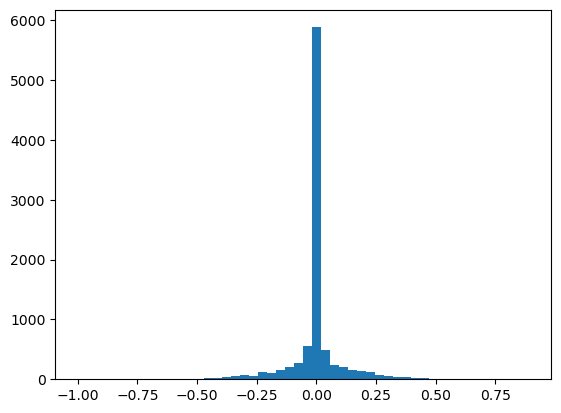

In [37]:
plt.hist(normalized,bins=50)

In [38]:
# i would expect the sound to have 0 mean? this is a Q for JoYo
# next step:
# # filter data? passband the PCG data to 1kHz and resample
# # add the noise to the PCG data (normalize noise first)
# # start to build classifier...
# # can create a stereo track and then combine it to mono?


### 1.d - Exploring ESC-50 dataset

What a blessed dataset. The sounds are so clean and useful, and well annotated.
Most useful classes:
- ['Rain', ' Wind', '  Pouring Water', ' Crying Baby', ' Sneezing', ' Breathing', ' Coughing', ' Footsteps', ' Laughing', ' Creaking', ' Washing Machine', ' Vaccuum', ' Helicopter', ' Siren']

In [39]:
x= 'aefewaa'

In [40]:
x[0].upper()+x[1:].lower()

'Aefewaa'

In [41]:
useful_classes = set(['rain',
 'wind',
 'pouring_water',
 'crying_baby',
 'sneezing',
 'breathing',
 'coughing',
 'footsteps',
 'laughing',
 'door_wood_creaks',
 'washing_machine',
 'vacuum_cleaner',
 'helicopter',
 'siren',
 'snoring'])

In [42]:
esc50_annos_raw = pd.read_csv(esc50_anno_path)

In [43]:
esc50_annos_raw.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [44]:
esc50_annos_raw.columns

Index(['filename', 'fold', 'target', 'category', 'esc10', 'src_file', 'take'], dtype='object')

In [45]:
esc50_annos_raw['category'].unique()

array(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm',
       'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks',
       'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train',
       'sheep', 'water_drops', 'church_bells', 'clock_alarm',
       'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow',
       'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter',
       'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine',
       'breathing', 'crying_baby', 'hand_saw', 'coughing',
       'glass_breaking', 'snoring', 'toilet_flush', 'pig',
       'washing_machine', 'clock_tick', 'sneezing', 'rooster',
       'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'],
      dtype=object)

In [46]:
useful_classes.difference(set(esc50_annos_raw['category']))

set()

In [47]:
esc50_subset_idx = esc50_annos_raw['category'].isin(useful_classes)

In [48]:
np.sum(esc50_subset_idx) # = 40 vids/class * num classes selected for

600

In [49]:
# what you'll be using
esc50_filtered = esc50_annos_raw[esc50_subset_idx]

In [50]:
len(esc50_filtered)

600

In [51]:
esc50_filtered.head()

,filename,fold,target,category,esc10,src_file,take
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
27,1-118559-A-17.wav,1,17,pouring_water,False,118559,A
37,1-137296-A-16.wav,1,16,wind,False,137296,A
39,1-155858-A-25.wav,1,25,footsteps,False,155858,A


In [52]:
esc50_good_idxs = list(esc50_filtered.index) # use for selecting random rows/files

### 1.e - Loading the Physionet 2016 Dataset

In [53]:
physio16_data_raw  = pd.read_csv(physio_anno_path)
num_recordings = physio16_data_raw.shape[0]

#### 1.e.1 - Removing Low Quality Recordings

In [54]:
training_a_sqi = physio16_path+'training-a/REFERENCE-SQI.csv'
training_a_sqi_data = pd.read_csv(training_a_sqi,names=['fname','normal-or-abnormal','SQI'],header=None)

training_b_sqi = physio16_path+'training-b/REFERENCE-SQI.csv'
training_b_sqi_data = pd.read_csv(training_b_sqi,names=['fname','normal-or-abnormal','SQI'])

training_c_sqi = physio16_path+'training-c/REFERENCE-SQI.csv'
training_c_sqi_data = pd.read_csv(training_c_sqi,names=['fname','normal-or-abnormal','SQI'])

training_d_sqi = physio16_path+'training-d/REFERENCE-SQI.csv'
training_d_sqi_data = pd.read_csv(training_d_sqi,names=['fname','normal-or-abnormal','SQI'])

training_e_sqi = physio16_path+'training-e/REFERENCE-SQI.csv'
training_e_sqi_data = pd.read_csv(training_e_sqi,names=['fname','normal-or-abnormal','SQI'])

training_f_sqi = physio16_path+'training-f/REFERENCE-SQI.csv'
training_f_sqi_data = pd.read_csv(training_f_sqi,names=['fname','normal-or-abnormal','SQI'])

In [55]:
training_a_sqi_data.head(3)

,fname,normal-or-abnormal,SQI
0,a0001,1,1
1,a0002,1,1
2,a0003,1,1


In [56]:
a_low_quality = training_a_sqi_data['SQI']<1

b_low_quality = training_b_sqi_data['SQI']<1

c_low_quality = training_c_sqi_data['SQI']<1

d_low_quality = training_d_sqi_data['SQI']<1

e_low_quality = training_e_sqi_data['SQI']<1

f_low_quality = training_f_sqi_data['SQI']<1

print(np.sum(a_low_quality),np.sum(b_low_quality),np.sum(c_low_quality),np.sum(d_low_quality),np.sum(e_low_quality), np.sum(f_low_quality))

17 122 4 3 213 5


In [57]:
low_a = set(training_a_sqi_data.loc[a_low_quality]['fname'])
low_b = set(training_b_sqi_data.loc[b_low_quality]['fname'])
low_c = set(training_c_sqi_data.loc[c_low_quality]['fname'])
low_d = set(training_d_sqi_data.loc[d_low_quality]['fname'])
low_e = set(training_e_sqi_data.loc[e_low_quality]['fname'])
low_f = set(training_f_sqi_data.loc[f_low_quality]['fname'])

In [58]:
# also use manual annotations for set b specifically
respiration_str = "Respiration noise (2=None 3=Insignificant 4=Weak Resp. Noise<2 s 5=Weak Resp. Noise<3 s 6=Weak Resp. Noise <4 s 7=Weak Resp. Noise >4 s 8=Powerfull Resp. Noise<2 s 9=Powerfull Resp. Noise<3 s 10=Powerfull Resp. noise <4 s  11=Powerfull Resp. Noise >4 s 12=Dont know 13=Weak Resp. Noise<1 s 14=Resp. Noise<1 s 15=Powerfull Resp. noise <1 s 16=Weak Rec. Noise<1 s 17=Powerfull Rec. Noise<1 s)"
ambient_str = "Ambient noise (2=None 3=Insignificant 4=Weak Rec. BG<2 s 5=Weak Rec. BG<3 s 6=Weak Rec. BG <4 s 7=Weak Rec. BG >4 s 8=BG. Noise<2 s 9=BG. Noise<3 s 10= BG. noise <4 s 11=BG. Noise >4 s 12=Powerfull BG. Noise<2 s 13=Powerfull BG. Noise<3 s 14=Powerfull BG. noise <4 s  15=Powerfull BG. Noise >4 s 16=Dont know 17=Weak BG. Noise<1 s  18=BG.Noise<1 s 19=Powerfull BG. Noise<1 s)"
noise_str = "Recording noise (2=None 3=Insignificant 4=Beg. Rec. Noise 5=End Rec. Noise 6=Beg-End Reco Noise 7=Weak Rec. Noise<2 s 8=Weak Rec. Noise<3 s 9=Weak Rec. Noise <4 s 10=Weak Rec. Noise >4 s 11=Powerfull Rec. Noise<2 s 12=Powerfull Rec. Noise<3 s 13=Powerfull Rec. noise <4 s 14=Powerfull Rec. Noise >4 s 15=Spikes 16=Dont know 17=Weak Rec. Noise<1 s 18=Powerfull Rec. Noise<1 s)"
abdominal_str = "Abdominal sounds (2=None 3=Insignificant 4=Sto. Noise<2 s 5=Sto. Noise<3 s 6=Sto. Noise <4 s 7=Sto. Noise >4 s 8=Dont know 9=Sto. Noise<1 s)"


# !impt: the cutoff is 5 (at time of writing). this means if a recording has p much any noise, it gets cut
# ... how restrictive do you want to be? 
cutoff_num = 6
noisy_data_b = physio16_data_raw.loc[(physio16_data_raw[respiration_str]>cutoff_num) 
                       | (physio16_data_raw[ambient_str]>cutoff_num)
                        | (physio16_data_raw[noise_str]>cutoff_num)
                        | (physio16_data_raw[abdominal_str]>cutoff_num)] # only tolerate very little noise

In [59]:
noisy_data_b.shape

(298, 26)

In [60]:
# these are the recordings in set b (which fortunately has annotations) which have noise
noisy_b_paths = set(noisy_data_b['Challenge record name'])

In [61]:
low_quality_physio16 = low_a | low_b | low_c | low_d | low_e | low_f | noisy_b_paths

In [62]:
print(f"{len(low_quality_physio16):<3} : Low quality recordings in entire dataset")
print(f"{len(low_quality_physio16.difference(noisy_b_paths)):<3} : Found based on SQI annotations")
print(f"{len(noisy_b_paths):<3} : Found based on set b's noise level annotations")

585 : Low quality recordings in entire dataset
287 : Found based on SQI annotations
298 : Found based on set b's noise level annotations


In [63]:
len(low_quality_physio16) # cut these out

585

In [64]:
rows_to_remove = physio16_data_raw['Challenge record name'].isin(low_quality_physio16)

In [65]:
# this is the final filtered data, for use during the remainder of this notebook
physio16_data = physio16_data_raw[~rows_to_remove]

In [66]:
len(physio16_data) # quite a bit regardless

2653

In [67]:
# relevant columns
normal_str_16 = "Class (-1=normal 1=abnormal)"
murmur_str_16 = "Murmurs (2=None 3=Weak 4=Strong 6=Unclear)"

In [68]:
# explicitly murmurs
murmur_locs = physio16_data_raw[murmur_str_16]>2 

In [69]:
# number of abnormal heartbeats, filtered vs non-filtered physionet
np.sum(physio16_data[normal_str_16]>0),np.sum(physio16_data_raw[normal_str_16]>0)

(538, 665)

In [70]:
physio16_data.head(10)

,Challenge record name,Database,Original record name,Diagnosis,Class (-1=normal 1=abnormal),# Beat (automated algorithm),# Beats requiring hand correction,Gender,Age (year),Height (m),...,# Recording in each subject,Transducer site on body,Recording state,Murmurs (2=None 3=Weak 4=Strong 6=Unclear),"Murmur Location (2=Sys,3=Dia,4=Both)",Arrhythmia (2=None 3=One arrhythmic beat 4=Medium Arrhytmia 5=Severe Arrhytmia 6=Unclear 7=Two arrhythmic beats),Respiration noise (2=None 3=Insignificant 4=Weak Resp. Noise<2 s 5=Weak Resp. Noise<3 s 6=Weak Resp. Noise <4 s 7=Weak Resp. Noise >4 s 8=Powerfull Resp. Noise<2 s 9=Powerfull Resp. Noise<3 s 10=Powerfull Resp. noise <4 s 11=Powerfull Resp. Noise >4 s 12=Dont know 13=Weak Resp. Noise<1 s 14=Resp. Noise<1 s 15=Powerfull Resp. noise <1 s 16=Weak Rec. Noise<1 s 17=Powerfull Rec. Noise<1 s),Ambient noise (2=None 3=Insignificant 4=Weak Rec. BG<2 s 5=Weak Rec. BG<3 s 6=Weak Rec. BG <4 s 7=Weak Rec. BG >4 s 8=BG. Noise<2 s 9=BG. Noise<3 s 10= BG. noise <4 s 11=BG. Noise >4 s 12=Powerfull BG. Noise<2 s 13=Powerfull BG. Noise<3 s 14=Powerfull BG. noise <4 s 15=Powerfull BG. Noise >4 s 16=Dont know 17=Weak BG. Noise<1 s 18=BG.Noise<1 s 19=Powerfull BG. Noise<1 s),Recording noise (2=None 3=Insignificant 4=Beg. Rec. Noise 5=End Rec. Noise 6=Beg-End Reco Noise 7=Weak Rec. Noise<2 s 8=Weak Rec. Noise<3 s 9=Weak Rec. Noise <4 s 10=Weak Rec. Noise >4 s 11=Powerfull Rec. Noise<2 s 12=Powerfull Rec. Noise<3 s 13=Powerfull Rec. noise <4 s 14=Powerfull Rec. Noise >4 s 15=Spikes 16=Dont know 17=Weak Rec. Noise<1 s 18=Powerfull Rec. Noise<1 s),Abdominal sounds (2=None 3=Insignificant 4=Sto. Noise<2 s 5=Sto. Noise<3 s 6=Sto. Noise <4 s 7=Sto. Noise >4 s 8=Dont know 9=Sto. Noise<1 s)
0,a0001,training-a,C45S1,MVP,1,36,0,NaN,NaN,NaN,...,NaN,Left of parasternum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,a0002,training-a,C19S3,MVP,1,27,7,NaN,NaN,NaN,...,NaN,Parasternum when sit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a0003,training-a,C23S0,MVP,1,25,0,NaN,NaN,NaN,...,NaN,Left of parasternum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,a0004,training-a,C35S18,Benign,1,35,0,NaN,NaN,NaN,...,NaN,Left of parasternum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,a0005,training-a,C63S20,Benign,1,52,0,NaN,NaN,NaN,...,NaN,Parasternum when squat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,a0007,training-a,C37S2,Normal,-1,52,27,NaN,NaN,NaN,...,NaN,Parasternum when sit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,a0009,training-a,C63S12,Normal,-1,46,0,NaN,NaN,NaN,...,NaN,Parasternum when squat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,a0010,training-a,C31S4,Benign,1,44,0,NaN,NaN,NaN,...,NaN,Parasternum when squat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,a0011,training-a,C37S0,Normal,-1,34,6,NaN,NaN,NaN,...,NaN,Left of apex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,a0012,training-a,C115S36,Normal,-1,28,4,NaN,NaN,NaN,...,NaN,Parasternum when sit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
sum(murmur_locs)

78

In [72]:
# !impt: this is really sad. filtering cut out half the murmurs
# of the 78 murmurs in physionet_raw, 32 were too noisy to be used
np.sum(physio16_data[murmur_str_16]>2)

35

In [73]:
np.sum(physio16_data[murmur_str_16]>1)

147

In [74]:
# so in total there are 66+35 = 101 murmurs, and ~2.9k total recordings
# this is a dilemma

### 1.f - Loading the Physionet 2022 Dataset

In [75]:
# that's really all. pre-processing will be for later. 
physio22_data = pd.read_csv(physio22_path+'all_annotations.csv')
physio22_pcgs_path = os.path.join(physio22_path,"all_data/")
physio22_pcg_list = os.listdir(physio22_pcgs_path)

In [76]:
def physio22_pcg_matches(pid):
    """
    In Physionet22, the same patient ID can map to several pcg recordings
    This function finds those recordings
    """
    all_matches =list(filter(lambda x: pid==x.split("_")[0] and x.endswith(".wav"), physio22_pcg_list))
    
    return all_matches

## 2 - Normalization

In [77]:
def lowpass_filter(signal_data, sampling_rate, cutoff_freq, order=4):
    nyquist = 0.5 * sampling_rate  # Nyquist frequency
    normal_cutoff = cutoff_freq / nyquist  # Normalize cutoff frequency
    
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = signal.filtfilt(b, a, signal_data)
    
    return filtered_signal

In [78]:
def plot_fourier_spectrum(audio_signal, sample_rate,step_size=10,title='Fourier Spectrum Magnitude'):
    plt.clf()
    # Compute the FFT
    fft_values = np.fft.fft(audio_signal)
    magnitude = np.abs(fft_values)  # Get magnitude spectrum
    freq = np.fft.fftfreq(len(audio_signal), d=1/sample_rate)  # Frequency axis

    # Keep only the positive frequencies (since this is real valued data)
    half_idx = len(freq) // 2
    freq = freq[:half_idx:step_size] # adding these steps 
    magnitude = magnitude[:half_idx:step_size]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(freq, magnitude)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title(title)
    plt.grid()
    plt.show()

In [79]:
# huge Q at this point. What gets resampled to what frequency? 
# # i suppose we are strictly interested in low-ish frequency noise (everything else
# ... would get nuked. )

Original shape: (557918,), Filtered shape: (557918,), Resampled shape: (12652,)


<Figure size 640x480 with 0 Axes>

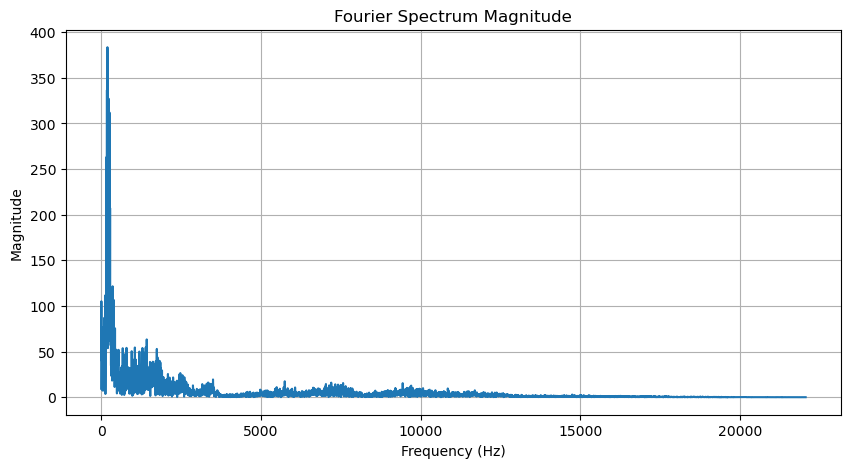

<Figure size 640x480 with 0 Axes>

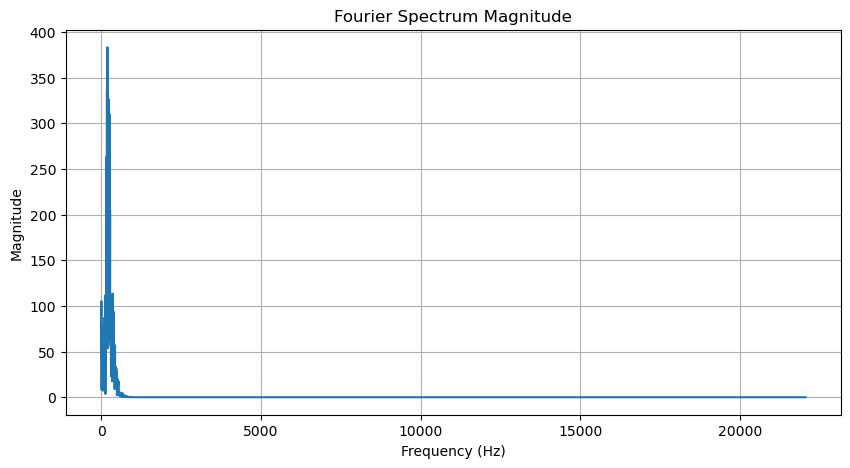

<Figure size 640x480 with 0 Axes>

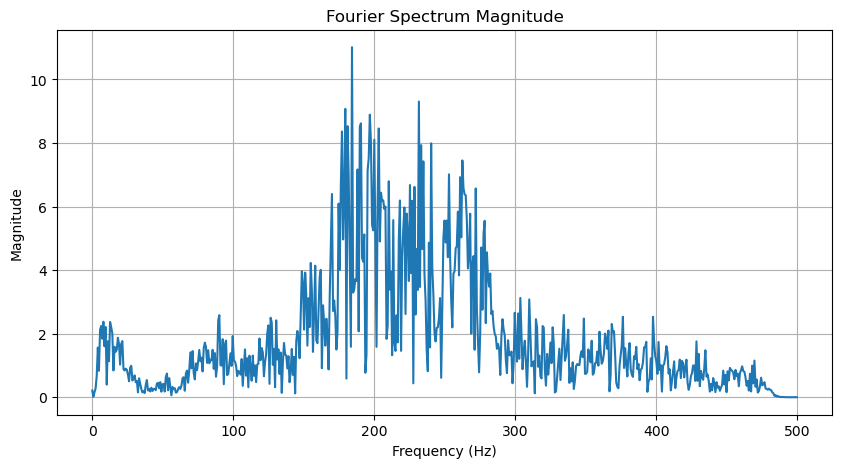

/Users/donu/Desktop/semesters/S25/ELEC 594/datasets/ARCA23K_audio/407722.wav


In [80]:
# Test 
cutoff_freq = 500
target_freq = cutoff_freq * 2

for wav in list_of_wavs:
    path_to_wav = arcawavs_path + str(wav) + '.wav'
    audiodata, sr = librosa.load(path_to_wav, sr=None)
    # Apply low-pass filter
    audio_data_new = lowpass_filter(audiodata, sr, cutoff_freq)

    # Resample the filtered signal
    new = librosa.resample(audio_data_new, orig_sr=sr, target_sr=target_freq)

    # Debugging info
    print(f"Original shape: {audiodata.shape}, Filtered shape: {audio_data_new.shape}, Resampled shape: {new.shape}")

    # Plot frequency content at each step
    plot_fourier_spectrum(audiodata, sr,step_size=50)  # Original
    plot_fourier_spectrum(audio_data_new, sr,step_size=50)  # After filtering
    plot_fourier_spectrum(new, target_freq,step_size=10)  # After resampling

    print(path_to_wav)
    break  # Stops after first file (as intended)


In [81]:
def load_from_filepath(filepath):
    """
    Load an audio file from a given file path and return the audio data and sample rate.
    """
    audio_data, sample_rate = librosa.load(filepath,sr=None)
    return audio_data, sample_rate

In [82]:
def downsample(audiodata, sr, target_freq):
  """
  Given a filepath for a wav, downsamples the audio to a target frequency
  (applies an LPF beforehand accordingly)
  """
  if sr<target_freq:
    raise Exception("Sample rate too low")
  if sr==target_freq: # this is the case for physionet
    # it was mentioned in pnet16 paper an anti-aliasing filter was already applied. just return audiodata
    return audiodata
  audio_data_new = lowpass_filter(audiodata, sr, target_freq//2)
  new = librosa.resample(audio_data_new, orig_sr=sr, target_sr=target_freq)
  return new

In [83]:
%%script false --no-raise-error # this cell has served its use
for wav in list_of_wavs:
  path_to_wav = arcawavs_path + str(wav) + '.wav'
  arca_data, arca_sr = load_from_filepath(path_to_wav)
  downsample(arca_data, arca_sr, 2000)

#### Comments
- I think a good enough idea is to LPF everything at 1kHz, then resample to 2kHz 

### 2.b - Examine Spectra of PCG Recordings

In [84]:
%%script false --no-raise-error 
# cell disabled (it served its purpose)
dsample_freq = 2000
fnames = pcg_data['fname'].tolist()
print(len(fnames))
for f_name in fnames[::-53]: # anything weird about the spectra?
  path_to_wav = pascal_dset_path + f_name
  pcg_recording, pcg_sr = load_from_filepath(path_to_wav)
  print(pcg_sr)
  #d_sampled = downsample(pcg_recording, pcg_sr, dsample_freq)
  plot_fourier_spectrum(pcg_recording,pcg_sr,step_size=50)
  #plot_fourier_spectrum(d_sampled, dsample_freq,step_size=50)  # Original

set_b/254_1309350589009_C.wav murmur
set_b/254_1309350589009_D.wav murmur
set_b/276_1311162716489_C.wav murmur


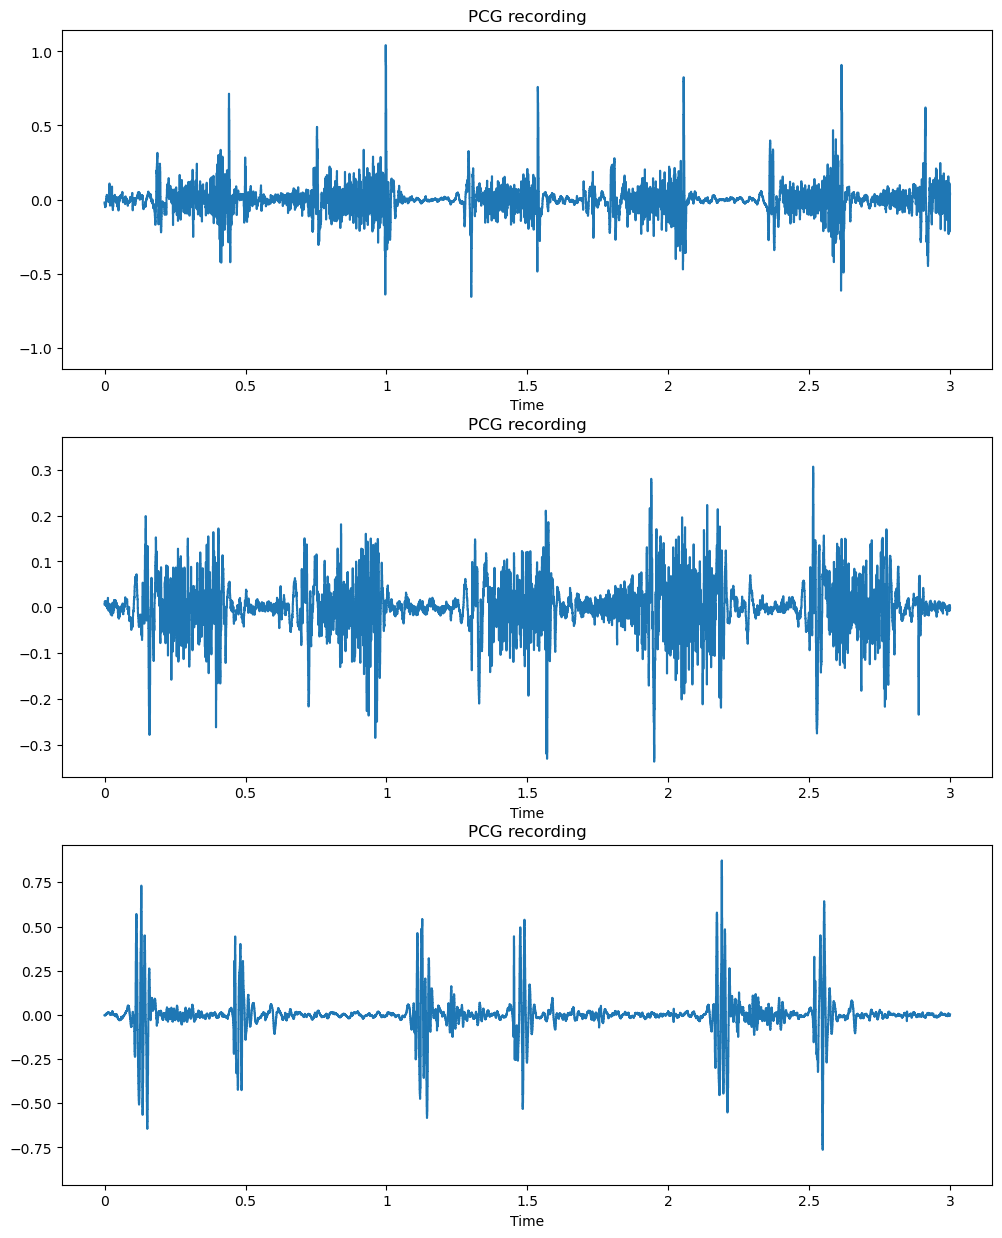

In [85]:
# examining the recordings in time as well

target_freq = 2000
num_to_show=3
startidx = 55

fig, ax = plt.subplots(nrows=num_to_show, figsize=(12, 5*num_to_show))
# want to show the same length for all of them actually. 3 seconds. 
good_idx = 0
for rowidx,row in pcg_data.iloc[startidx:,:].reset_index().iterrows():
  if num_to_show<=good_idx: 
    break
  
  # recording name and type
  fname = row['fname']
  fpath = pascal_dset_path+fname
  
  # load the data
  data, sr = load_from_filepath(fpath)
  length_of_rec = len(data)/sr
  # want to plot the same length for all recordings
  if length_of_rec<=3: 
    continue
  # good to plot
  print(fname, row['label'])
  #print(max(data))
  data = downsample(data,sr,target_freq) # downsampled data
  #print(max(data))
  ax[good_idx].set(title='PCG recording')
  #ax[1].set(title='PCG+Noise')
  librosa.display.waveshow(data[:target_freq*3],sr=target_freq,ax=ax[good_idx]) # original data
  good_idx+=1
  
# data either looks ok ish or horrible

## 3 - Signal Combination

In [86]:
def get_random_noise_path():
  random_wav = random.choice(list_of_wavs)
  #label = noise_data[noise_data['fname'] == random_wav]['label'].values[0]
  #print(f'ARCA23K file: {random_wav}. Noise Type: {label}') # obnoxious
  # !impt: there seems to be an enormous rate of mislabelling. terrible dset...
  return arcawavs_path + str(random_wav) + '.wav'

In [87]:
def get_n_random_noise_paths_arca(n):
  return [arcawavs_path + str(x) + '.wav' for x in random.sample(list_of_wavs, n)]

In [88]:
def get_n_random_noise_paths_han(n):
  return [han_raw_path + x for x in random.sample(os.listdir(han_raw_path), n)]

In [89]:
def get_n_random_noise_paths_esc(n):
  random_rows = random.sample(esc50_good_idxs,n)
  filenames = esc50_filtered['filename'][random_rows]
  #print(esc50_filtered['category'][random_rows])
  return [esc50_path+'audio/'+filename for filename in filenames]

In [90]:
get_n_random_noise_paths_esc(3)

['/Users/donu/Desktop/semesters/S25/ELEC 594/datasets/ESC-50/audio/2-91912-A-33.wav',
 '/Users/donu/Desktop/semesters/S25/ELEC 594/datasets/ESC-50/audio/4-198025-A-23.wav',
 '/Users/donu/Desktop/semesters/S25/ELEC 594/datasets/ESC-50/audio/4-144083-A-16.wav']

In [91]:
len(data)

12434

In [92]:
path_to_plot = get_n_random_noise_paths_esc(1)[0]
data, sr = load_from_filepath(path_to_plot)
Audio(data=data,rate=sr)

In [93]:
#%script false --no-raise-error
# !impt: IPython playback doesn't work for SR below 3k. 
# # this is sad because I'd like to listen to my downsampled files
# # however qualitatively if i downsample just above 3k and listen, things sound nice
# # from this i conclude that my downsample function is working as intended
dataa = downsample(data, sr, 4050)
downsampled = np.asarray(dataa, dtype=np.float32)

# Correct normalization logic
ds_max = np.max(np.abs(downsampled))
#if ds_max> 1:
#downsampled /= ds_max

# Then play it
Audio(data=downsampled, rate=4050)

44100
0.57476807 -0.67822266
post 0.5514851212501526
44100
0.07577515 -0.10015869
post 0.06987809389829636


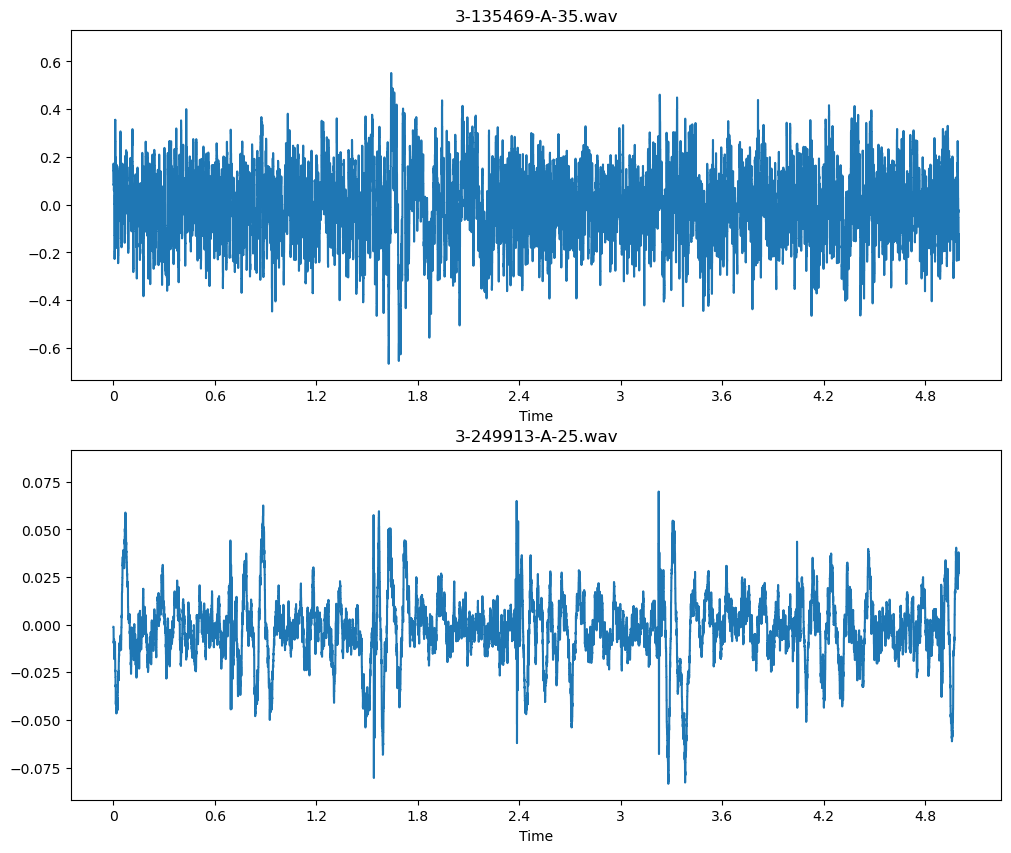

In [94]:
# plot esc sounds
plot_n = 2
fig, ax = plt.subplots(nrows=plot_n, figsize=(12, 5*plot_n))
for plotidx,path in enumerate(get_n_random_noise_paths_esc(plot_n)):
  data, sr = load_from_filepath(path)
  print(sr)
  print(np.max(data),np.min(data))
  data = downsample(data,sr,target_freq)
  librosa.display.waveshow(data[:target_freq*5],sr=target_freq,ax=ax[plotidx]) # original data
  print(f"post {np.max(data)}")
  
  ax[plotidx].set(title=f'{path.split("/")[-1]}')
  #ax[1].set(title='PCG+Noise')

In [95]:
get_n_random_noise_paths_arca(5)

['/Users/donu/Desktop/semesters/S25/ELEC 594/datasets/ARCA23K_audio/390691.wav',
 '/Users/donu/Desktop/semesters/S25/ELEC 594/datasets/ARCA23K_audio/458372.wav',
 '/Users/donu/Desktop/semesters/S25/ELEC 594/datasets/ARCA23K_audio/445921.wav',
 '/Users/donu/Desktop/semesters/S25/ELEC 594/datasets/ARCA23K_audio/69300.wav',
 '/Users/donu/Desktop/semesters/S25/ELEC 594/datasets/ARCA23K_audio/376293.wav']

0.77124023 -1.0
post 0.6944400072097778
0.82110596 -1.0
post 0.37254467606544495


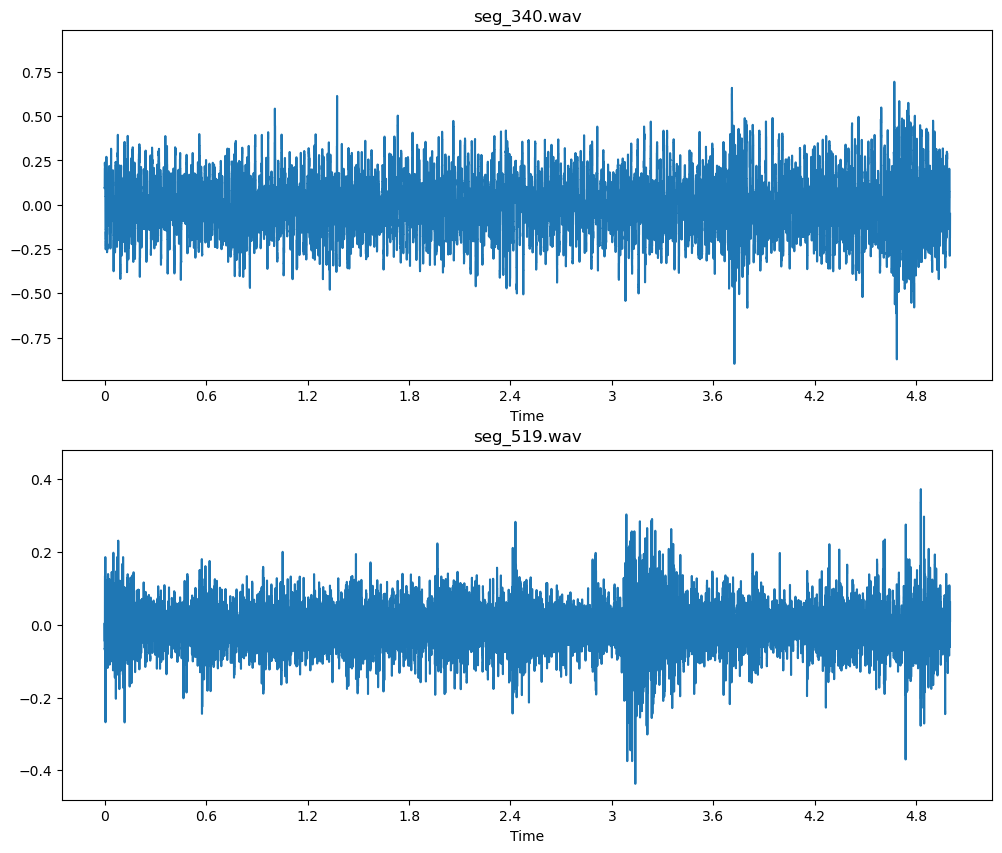

In [96]:
plot_n = 2
fig, ax = plt.subplots(nrows=plot_n, figsize=(12, 5*plot_n))
for plotidx,path in enumerate(get_n_random_noise_paths_han(plot_n)):
  data, sr = load_from_filepath(path)
  print(np.max(data),np.min(data))
  data = downsample(data,sr,target_freq)
  librosa.display.waveshow(data[:target_freq*5],sr=target_freq,ax=ax[plotidx]) # original data
  print(f"post {np.max(data)}")
  ax[plotidx].set(title=f'{path.split("/")[-1]}')
  #ax[1].set(title='PCG+Noise')

0.75756836 -0.9885254
post 0.6309237480163574
0.9999695 -1.0
post 0.2715710401535034


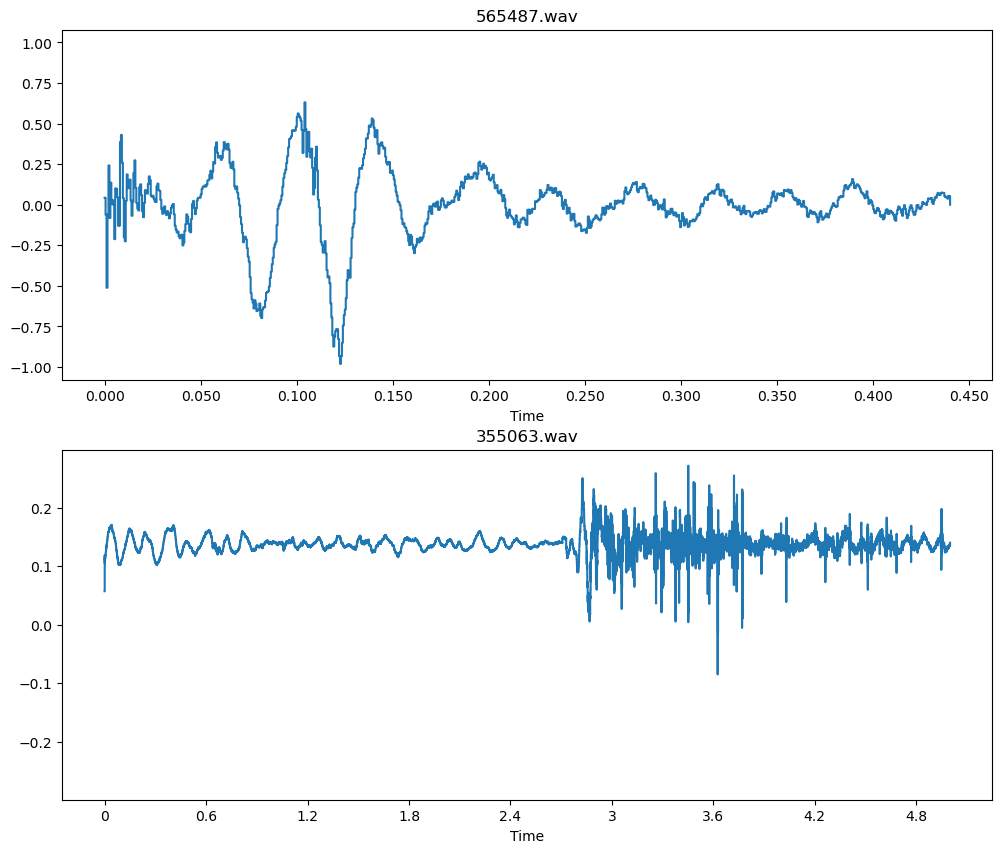

In [97]:
plot_n = 2
fig, ax = plt.subplots(nrows=plot_n, figsize=(12, 5*plot_n))
for plotidx,path in enumerate(get_n_random_noise_paths_arca(plot_n)):
  data, sr = load_from_filepath(path)
  print(np.max(data),np.min(data))
  data = downsample(data,sr,target_freq)
  librosa.display.waveshow(data[:target_freq*5],sr=target_freq,ax=ax[plotidx]) # original data
  print(f"post {np.max(data)}")
  ax[plotidx].set(title=f'{path.split("/")[-1]}')
  #ax[1].set(title='PCG+Noise')

In [98]:
get_n_random_noise_paths_han(5)

['/Users/donu/Desktop/semesters/S25/ELEC 594/datasets/hospital-noise-original/seg_188.wav',
 '/Users/donu/Desktop/semesters/S25/ELEC 594/datasets/hospital-noise-original/seg_82.wav',
 '/Users/donu/Desktop/semesters/S25/ELEC 594/datasets/hospital-noise-original/seg_217.wav',
 '/Users/donu/Desktop/semesters/S25/ELEC 594/datasets/hospital-noise-original/seg_137.wav',
 '/Users/donu/Desktop/semesters/S25/ELEC 594/datasets/hospital-noise-original/seg_189.wav']

In [99]:
noise_data

,fname,label,mid
0,507,Acoustic_guitar,/m/042v_gx
1,251090,Acoustic_guitar,/m/042v_gx
2,161470,Acoustic_guitar,/m/042v_gx
3,18489,Acoustic_guitar,/m/042v_gx
4,251185,Acoustic_guitar,/m/042v_gx
...,...,...,...
17974,463104,Zipper_(clothing),/m/01s0vc
17975,575516,Zipper_(clothing),/m/01s0vc
17976,403656,Zipper_(clothing),/m/01s0vc
17977,562333,Zipper_(clothing),/m/01s0vc


In [100]:
get_random_noise_path() # this does get a random noise

'/Users/donu/Desktop/semesters/S25/ELEC 594/datasets/ARCA23K_audio/328783.wav'

In [101]:
def match_signal_and_noise_lengths(signal, noise):
  """
  Given a signal and noise, makes the noise the same length as signal
  through duplicating, then truncating
  - truncating the noise
  """
  signal_len = len(signal)
  noise_len = len(noise)
  
  if signal_len > noise_len:
    # Repeat the noise to match the signal length
    noise = np.tile(noise, signal_len // noise_len + 1)
  noise = noise[:signal_len]
  return noise

In [102]:
match_signal_and_noise_lengths(np.array([1,2,3,4,5,6,7]),np.array([1,2,3]))

array([1, 2, 3, 1, 2, 3, 1])

In [103]:
match_signal_and_noise_lengths(np.array([1,2]),np.array([3,2,1]))

array([3, 2])

In [107]:
def create_composite_at_snr(signal,noise,snr_db):
  """
  Function to combine two audio arrays, one signal one noise, at a given SNR
  
  SNR is in dB
  """
  signal_power = avg_power(signal)
  noise_power = avg_power(noise)
  if np.round(noise_power,7) == 0:
    #print('Noise power is 0. Returning signal only') !impt
    return signal
  ratio = np.sqrt((signal_power / noise_power) / (10 ** (snr_db / 10)))
  noise *= ratio
  return signal + noise

In [108]:
def create_composite(pcg_raw, pcg_sr, noise_raw, noise_sr, target_freq, snr):
  """
  A top-level function that combines the above functions to create a composite sound.
  
  Given a PCG filepath and a noise filepath, creates a composite sound by adding the two together.
  Both files are downsampled to the target frequency.
  
  
  Inputs:
  - pcg_filepath
  - noise_filepath
  - target_freq: the frequency to downsample the pcg data and noise data to
  - snr: desired SNR in dB of the combined sounds
  
  Returns the (downsampled) ground truth PCG data and the composite sound, an
  the maximum value of the composite sound before rescaling.
  """
  pcg = downsample(pcg_raw, pcg_sr, target_freq) # downsample the PCG data
  pcg = rescale_pcg(pcg) # !impt: renormalize pcg data. resume work here
  noise = downsample(noise_raw, noise_sr, target_freq)
  noise = match_signal_and_noise_lengths(pcg, noise) # they are now the same size
  composite = create_composite_at_snr(pcg, noise, snr) # combine the two
  mval_composite = np.max(np.abs(composite))
  composite = rescale_pcg(composite) # normalize. I think this is good... 
  
  return pcg, composite, mval_composite # composite. Return mval for accurate SNR calculation way later

<Figure size 640x480 with 0 Axes>

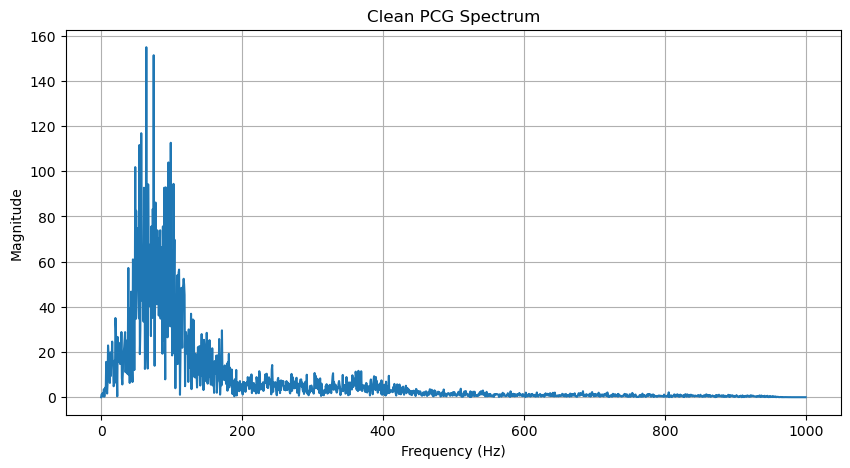

<Figure size 640x480 with 0 Axes>

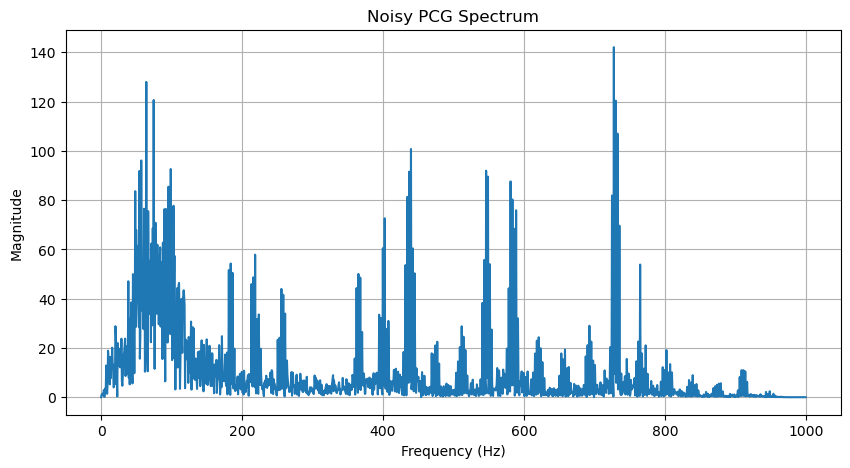

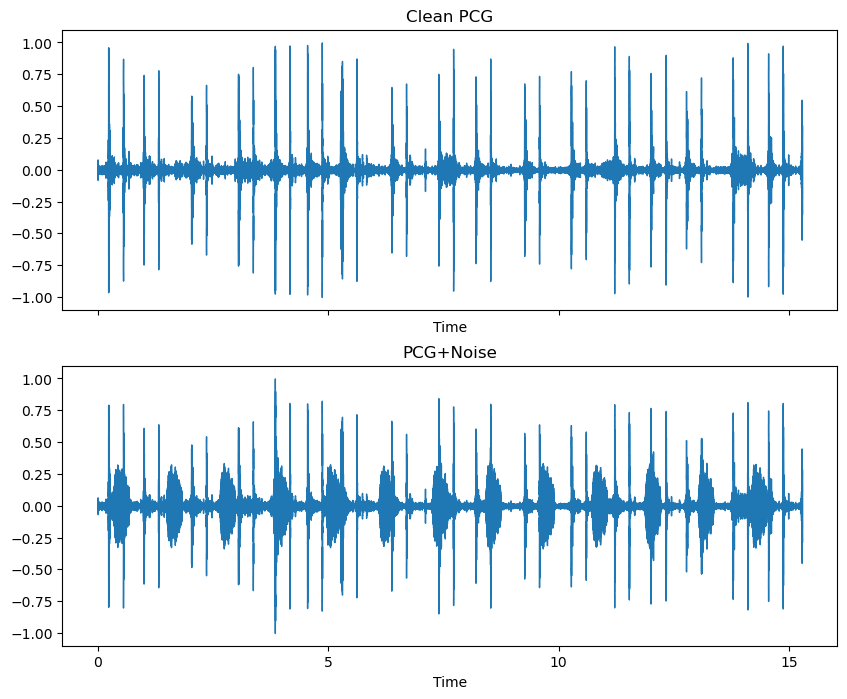

In [109]:
# proof of concept: see the spectrum of a clean PCG and a composite sound
target_freq = 2000 # downsample to this
snr_db = 3
for clean_pcg in pcg_data['fname'][2:]:
  if not clean_pcg.endswith('.wav'): # avoid .DS_Store among other things
    continue
  pcg_filepath = pascal_dset_path + clean_pcg
  random_noise = get_random_noise_path()
  
  pcg_raw, pcg_sr = load_from_filepath(pcg_filepath)
  #print(np.min(pcg_raw),np.max(pcg_raw)) # for seeing range
  noise_raw, noise_sr = load_from_filepath(random_noise)
  
  clean, composite, mval = create_composite(pcg_raw, pcg_sr, noise_raw, noise_sr, target_freq,snr_db)
  # here is where el magico happenso. 
  # look at all the functions you wrote and find a use for them 
  # # e.g. downsample_from_filepath
  
  clean -= np.mean(clean) # DC components shouldn't be useful...?
  #print(np.min(clean),np.max(clean)) # for seeing range
  composite -= np.mean(composite)
  # now visualize. in frequency:
  plot_fourier_spectrum(clean,target_freq,step_size=10,title = 'Clean PCG Spectrum')
  plot_fourier_spectrum(composite,target_freq,step_size=10,title = 'Noisy PCG Spectrum')
  # in time
  fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))
  ax[0].set(title='Clean PCG')
  ax[1].set(title='PCG+Noise')
  librosa.display.waveshow(clean,sr=target_freq,ax=ax[0])
  librosa.display.waveshow(composite,sr=target_freq,ax=ax[1])
  break

In [110]:
#!impt: so, there is often a huge DC component introduced. i am not sure why this is.
# perhaps the NN will learn to discard it, which would be fine. 
# but, it's also a pretty simple thing to discard

## 4 - (Legacy) Making the STFT features

In [111]:
from scipy.signal import ShortTimeFFT

In [112]:
#ShortTimeFFT()
nperseg = 1024
hann = signal.windows.hann(nperseg)

In [113]:
SFT = ShortTimeFFT(hann, hop=nperseg//4, fs = target_freq)

### 4.a - Creating Inputs and outputs for the model

In [114]:
unique_shapes, unique_shapes_2 = set(), set()

input_stft_data = []
output_stft_data = []

for pcg_local_path in pcg_data['fname']:
  if not pcg_local_path.endswith('.wav'): # avoid .DS_Store among other things
    continue
  if not wav_lengths[pcg_local_path] > CUTOFF_SECONDS:
    continue
  # here we have a problem with the function about "create composite from filepaths"
  pcg_filepath = pascal_dset_path + clean_pcg
  random_noise = get_random_noise_path()
  
  pcg_raw, pcg_sr = load_from_filepath(pcg_filepath)
  noise_raw, noise_sr = load_from_filepath(random_noise)
  pcg_raw = pcg_raw[:CUTOFF] # truncate the PCG data, to 2 seconds. 

  clean, composite, mval = create_composite(pcg_raw, pcg_sr, noise_raw, noise_sr, target_freq,snr_db)
  clean -= np.mean(clean)
  composite -= np.mean(composite)

  # now, stft:
  stft_clean = SFT.stft(clean)
  unique_shapes.add(tuple(stft_clean.shape)) # everything is 513x18
  stft_noisy = SFT.stft(composite)
  unique_shapes_2.add(tuple(stft_noisy.shape)) # everything is 513x18
  
  input_stft_data.append(stft_noisy[2])
  output_stft_data.append(stft_clean[2])
#print(unique_shapes,unique_shapes_2)
# !impt: 151 sounds in total, of which 126 are unique. the most prevalent sound occurs 4 times.abs
# # (there is a bit of re-use overall)

<Figure size 640x480 with 0 Axes>

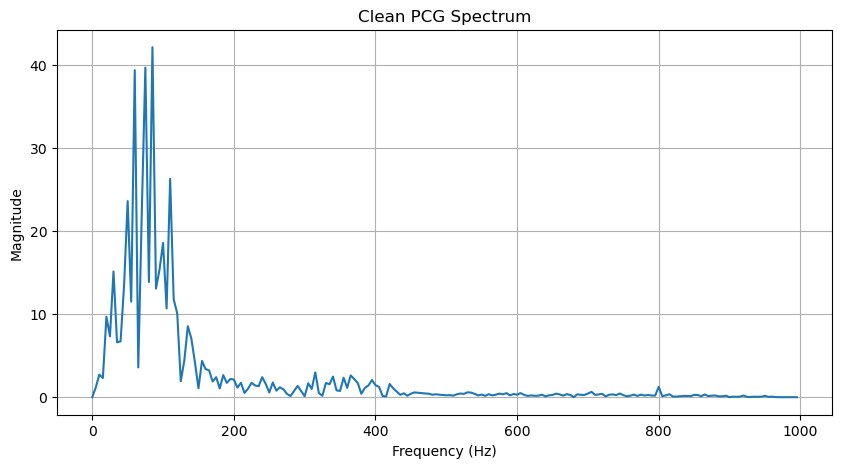

<Figure size 640x480 with 0 Axes>

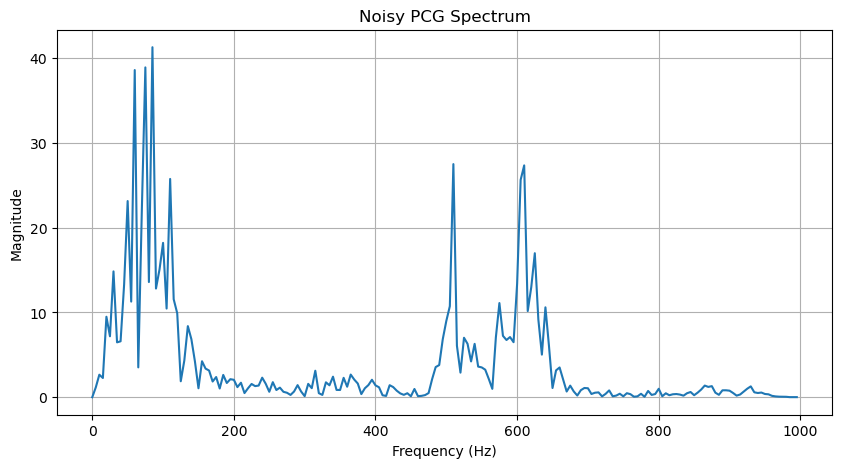

In [115]:
plot_fourier_spectrum(clean,target_freq,step_size=10,title = 'Clean PCG Spectrum')
plot_fourier_spectrum(composite,target_freq,step_size=10,title = 'Noisy PCG Spectrum')

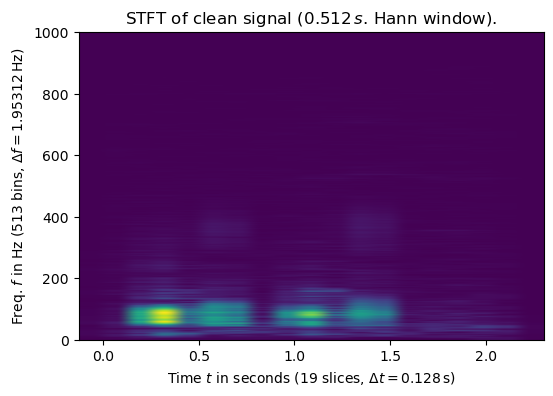

In [116]:
fig1, ax1 = plt.subplots(figsize=(6., 4.))
N = len(clean)
t_lo, t_hi = SFT.extent(N)[:2]
ax1.set_title(rf"STFT of clean signal ({SFT.m_num*SFT.T:g}$\,s$. Hann window).")
ax1.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))

im1 = ax1.imshow(abs(stft_clean), origin='lower', aspect='auto',
                 extent=SFT.extent(N), cmap='viridis')

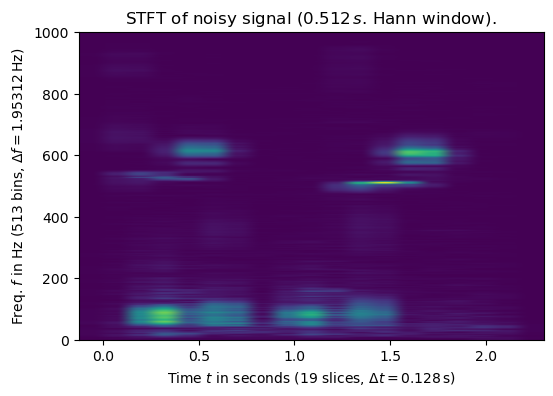

In [117]:
fig2, ax2 = plt.subplots(figsize=(6., 4.))
N = len(clean)
t_lo, t_hi = SFT.extent(N)[:2]
ax2.set_title(rf"STFT of noisy signal ({SFT.m_num*SFT.T:g}$\,s$. Hann window).")
ax2.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))

im2 = ax2.imshow(abs(stft_noisy), origin='lower', aspect='auto',
                 extent=SFT.extent(N), cmap='viridis')

In [118]:
#stft_noisy # this is complex. should the real and imag parts be split?

In [119]:
# !impt: do i have enough data? So far, 200-some noisy samples...
# ways to get more data:
# # add multiple noise copies to each PCG sample

## 5 - Making Training and Test Data

### 5.a - Functions to combine clean PCGs with noises

In [120]:
def murmur_presence_pascal(fname):
  murmur_here = pcg_data['label'][pcg_data['fname']==fname]
  return murmur_here.item() == 'murmur'

In [121]:
def murmur_presence_physio16(fname):
  # presupposes that fname exists
  fname_reduced = fname[:-4]
  murmur_here = physio16_data[murmur_str_16][physio16_data['Challenge record name']==fname_reduced]
  return murmur_here.item() > 2 # i.e. if murmur is at least weak

In [122]:
def murmur_presence_physio22(fname):
  # "fname" is just a patient id. the corresponding files would be PID_AV.wav or PID_MV.wav or something
  murmur_here = physio22_data[physio22_data["Patient ID"]==int(fname)]["Murmur"]=="Present"
  return murmur_here.item()

In [123]:
murmur_presence_physio22(9979)

True

In [124]:
physio22_data.head()

,Patient ID,Recording locations,Age,Sex,Height,Weight,Pregnancy status,Murmur,Murmur locations,Most audible location,...,Systolic murmur pitch,Systolic murmur quality,Diastolic murmur timing,Diastolic murmur shape,Diastolic murmur grading,Diastolic murmur pitch,Diastolic murmur quality,Outcome,Campaign,Additional ID
0,2530,AV+PV+TV+MV,Child,Female,98.0,15.9,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
1,9979,AV+PV+TV+MV,Child,Female,103.0,13.1,False,Present,AV+MV+PV+TV,TV,...,High,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
2,9983,AV+PV+TV+MV,Child,Male,115.0,19.1,False,Unknown,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
3,13918,AV+PV+TV+MV,Child,Male,98.0,15.9,False,Present,TV,TV,...,Low,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
4,14241,AV+PV+TV+MV,Child,Male,87.0,11.2,False,Present,AV+MV+PV+TV,PV,...,Low,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN


In [125]:
# test results here
murmur_sum_16 = np.sum([murmur_presence_physio16(crn+'.wav') for crn in physio16_data['Challenge record name']]) # num of included murmurs
murmur_sum_22 = np.sum([murmur_presence_physio22(pid) for pid in physio22_data["Patient ID"]])
print(murmur_sum_16,murmur_sum_22) # these are both good

35 305


In [126]:
idx_to_set = ['training','val','test']

def create_segments(dset_name,pcg_path,num_noises,snr_db,segment_length,pairs,idx):
  """ 
  Given a pcg path and a set of noises, add the noises to copies of the PCG
  
  Inputs:
  - dset_name: What dataset the PCG came from (valid inputs: pascal, physio16, physio22)
  - pcg_path: The file path to the PCG 
    #!impt: pcg_path should reflect the local path of the signal within its dataset
  - num_noises: Array containing integers being the # of noises to take from each noise dataset
  - snr_db: Array of SNR values to combine the PCG and the noises at
  - segment_length: Desired length of each segment (in terms of array length) 
  - pairs: An array to store metadata
  - idx: integer, 0,1,2, representing split (0=training, 1=val, 2=test)
  Returns three arrays: clean PCG segments, noisy PCG segments, and metadata about segments
  """
  from_pascal,from_physio16,from_physio22 = 0,0,0 #keep track of where the PCGs came from
  
  signal_paths = []
  if dset_name =='pascal': 
    signal_paths = [pascal_dset_path + pcg_path]
    murmur_present = murmur_presence_pascal(pcg_path) 
    from_pascal = 1
    
  elif dset_name =='physio16': # here pcg_path is expected to be dataset+fname (e.g. training-a/a0001.wav)
    signal_paths = [physio16_path + pcg_path]
    fname = pcg_path.split('/')[-1]
    murmur_present = murmur_presence_physio16(fname)
    from_physio16 = 1
  
  elif dset_name == 'physio22': # pcg path is kind of a misnomer. in this case it's just a PID string
    file_matches = physio22_pcg_matches(pcg_path) # the "pcg_path" is just a PID. a variable # of PCGs can be attached 
    # ... to each PID
    signal_paths = [physio22_pcgs_path + fname for fname in file_matches]
    murmur_present = murmur_presence_physio22(pcg_path)
    from_physio22 = 1
  
  if not signal_paths:
    print("Dataset doesn't exist.")
    return 0
  
  clean_pcgs = []
  noisy_pcgs = []
  metadata = []
  
  # where the noises get added. Keep doing += for each new dataset
  noises_to_look_at = get_n_random_noise_paths_han(num_noises[0])
  noises_to_look_at += get_n_random_noise_paths_arca(num_noises[1])
  noises_to_look_at += get_n_random_noise_paths_esc(num_noises[2])
  
  for signal_filepath in signal_paths:
    signal_raw, signal_sr = load_from_filepath(signal_filepath)
    for snr in snr_db:
      # get a random noises from the han dataset
      for noise_path in noises_to_look_at: 
        # load noise and create composite
        noise_raw, noise_sr = load_from_filepath(noise_path)
        clean, composite, mval = create_composite(signal_raw, signal_sr, noise_raw, noise_sr, target_freq, snr)
        
        local_noise_path = noise_path.split('datasets/')[-1] # !impt: here we assume that we keep the datasets/ dir
        pairs[idx].append([idx_to_set[idx], dset_name, pcg_path, local_noise_path,snr,murmur_present])
        # cut each pair of recordings into fixed length subsections
        for i in range(0,len(clean)//segment_length):
          # segmentation
          clean_subsection = clean[i*segment_length:(i+1)*segment_length]
          composite_subsection = composite[i*segment_length:(i+1)*segment_length]
          # append
          clean_pcgs.append(clean_subsection)
          noisy_pcgs.append(composite_subsection)
          # metadata
          metadata.append(np.array([mval,snr,murmur_present,from_pascal,from_physio16,from_physio22])) # !impt: this is metadata structure
          # if this changes should change metadata_shape variable too

  return clean_pcgs, noisy_pcgs, metadata

#### 5.b - Prep work for generating synthetically noisy PCGs

In [127]:
gen = torch.Generator().manual_seed(seed) # this is new!

In [128]:
# get each pcg path from each dataset. tuple of form (dsetname, path)
pcgpaths_pascal = [('pascal',x) for x in pcg_data['fname']]

In [129]:
# for physionet
pcgpaths_physio16 = []
for index, row in physio16_data.iterrows():
  pcgpaths_physio16.append(('physio16',row['Database']+'/'+row['Challenge record name']+'.wav'))

In [130]:
pcgpaths_physio22 = []
for index, row in physio22_data.iterrows():
  pcgpaths_physio22.append(('physio22', str(row['Patient ID'])))

In [131]:
# combine all
pcg_paths = pcgpaths_pascal + pcgpaths_physio16 + pcgpaths_physio22

In [132]:
# do this to ensure that no PCG is in more than 1 of the train/test/val datasets
fnames_np_pascal = pcg_data['fname'].to_numpy()
# !impt: split distribution
train_pct, val_pct, test_pct = .7,.1,.2
training_list,val_list,test_list = torch.utils.data.random_split(pcg_paths,[train_pct,val_pct,test_pct],generator=gen)

inpt_data = [[],[],[]]
outpt_data = [[],[],[]]
metadata_data = [[],[],[]]

In [133]:
total_pcg_count = sum([len(training_list),len(val_list),len(test_list)])
total_pcg_count

4487

In [134]:
pairs = [[],[],[]] # training, val, test 
# !impt: format = (which_dset, pcg_path, noise_path, snr)

In [135]:
# !impt: This cell shapes everything about how data is created 
target_freq = 2000 # downsample to this
snr_db = [-3,0,3,6]
seconds_per_segment = 0.8
segment_length = int(target_freq*seconds_per_segment)
# determines dataset size
han_inputs, arca_inputs, esc_inputs = 2, 0, 2 # arca is useless
num_noises = [han_inputs,arca_inputs,esc_inputs]

### 5.c - Allocating memory

#### 5.c.1 - Pre-compute dataset sizes

In [136]:
# it is very helpful to know in advance how large your datasets will be
# this is useful for memmap
def len_of_split(list_of_pcgs):
  """
  Returns the amount of PCG segments that will eventually come from a list of PCGs
  """
  # total number of segments
  total = 0
  
  for dataset_name, pcg_path in list_of_pcgs:
    # list_of_pcgs is of form (dset, path). e.g. ('physio16','training-a/a0001.wav')
    signal_filepaths = []
    if dataset_name =='pascal': 
      signal_filepaths = [pascal_dset_path + pcg_path]
    if dataset_name =='physio16': # here pcg_path is expected to be dataset+fname (e.g. training-a/a0001.wav)
      signal_filepaths = [physio16_path + pcg_path]
    if dataset_name == 'physio22':
      # find all matching wavs, and calc length independently
      file_matches = physio22_pcg_matches(pcg_path) # i.e. PID, since these should just be vals from physio22["Patient ID"]
      signal_filepaths = [physio22_pcgs_path + fname for fname in file_matches]
    # algebra below
    for signal_filepath in signal_filepaths:
      signal_raw, signal_sr = load_from_filepath(signal_filepath)
      # this comes from how librosa.resample is implemented
      signal_size = ceil(target_freq * len(signal_raw) / signal_sr)
      # overall result!
      total += len(snr_db)*sum(num_noises)*(signal_size//segment_length)

  return total

In [137]:
# debug
splitlen_real = [[],[],[]]

In [138]:
sr_real = [[],[],[]]

In [139]:
# finding dataset size
training_size, val_size, test_size = len_of_split(training_list),len_of_split(val_list),len_of_split(test_list)
METADATA_SHAPE = 6 # !impt: this comes from how long the metadata is when create_segments is run 
# there are 9 things to make, i.e. each combination of (train,val,test) and (inputs,outputs,meta)

# training-x, val-x, test-x will have a length of training_size,val_size,test_size
# x-inputs and x-outputs will have a length of segment_length, x-meta will have a length of 5 for the time being

# note that the below is necessary for loading in the data later.
# ... fortunately it is easy to calculate on-site (<3 sec)
# for in/out
in_out_shape_training = (training_size,segment_length)
in_out_shape_val = (val_size,segment_length)
in_out_shape_test = (test_size,segment_length)

# for metadata
meta_shape_training = (training_size,METADATA_SHAPE)
meta_shape_val = (val_size,METADATA_SHAPE)
meta_shape_test = (test_size,METADATA_SHAPE)
# proceeding:
general_info = {"training_input_output_dims": in_out_shape_training,
               "val_input_output_dims": in_out_shape_val,
               "test_input_output_dims": in_out_shape_test,
               "training_metadata_dims": meta_shape_training,
               "val_metadata_dims": meta_shape_val,
               "test_metadata_dims": meta_shape_test,
               "segment_length": segment_length,
               "target_freq": target_freq,
               "snr_db": snr_db,
               "num_noises": num_noises,
               "seconds_per_segment": seconds_per_segment,
               "metadata_shape": METADATA_SHAPE}

#### 5.c.2 - Path Definitions

In [140]:
training_size, val_size, test_size # these numbers make sense

(2544560, 371760, 748976)

In [141]:
# relevant paths for where things will be stored
train_inputs_loc = split_dir+'training_inputs.dat'
val_inputs_loc = split_dir+'val_inputs.dat'
test_inputs_loc = split_dir+'test_inputs.dat'
# # outputs
train_outputs_loc = split_dir+'training_outputs.dat'
val_outputs_loc = split_dir+'val_outputs.dat'
test_outputs_loc = split_dir+'test_outputs.dat'
# # metadata
train_meta_loc = split_dir+'training_meta.dat'
val_meta_loc = split_dir+'val_meta.dat'
test_meta_loc = split_dir+'test_meta.dat'

# also initialize path where metadata for full-length PCGs is stored as csv
save_path_metadata = split_dir+'metadata.csv'
# and where 
# dimension data will be stored
save_path_info = split_dir+"general_info.json"

In [142]:
split_dir

'/Users/donu/Desktop/semesters/S25/ELEC 594/storage/'

In [143]:
test_meta_loc

'/Users/donu/Desktop/semesters/S25/ELEC 594/storage/test_meta.dat'

### 5.c.3 - Allocate Memory

In [144]:
# define filepaths where data will be stored
# # since the mode is r+ an error will probably be thrown if the train_inputs_loc doesn't exist already
memmap_type = 'float32'
general_info["memmap_type"] = memmap_type
# inputs
train_inputs = np.memmap(train_inputs_loc, dtype=memmap_type, mode='r+', shape = in_out_shape_training)
val_inputs = np.memmap(val_inputs_loc, dtype=memmap_type, mode='r+', shape = in_out_shape_val)
test_inputs = np.memmap(test_inputs_loc, dtype=memmap_type, mode='r+', shape = in_out_shape_test)
# outputs
train_outputs = np.memmap(train_outputs_loc, dtype=memmap_type, mode='r+', shape = in_out_shape_training)
val_outputs = np.memmap(val_outputs_loc, dtype=memmap_type, mode='r+', shape = in_out_shape_val)
test_outputs = np.memmap(test_outputs_loc, dtype=memmap_type, mode='r+', shape = in_out_shape_test)
# meta
train_meta = np.memmap(train_meta_loc, dtype=memmap_type, mode='r+', shape = meta_shape_training)
val_meta = np.memmap(val_meta_loc, dtype=memmap_type, mode='r+', shape = meta_shape_val)
test_meta = np.memmap(test_meta_loc, dtype=memmap_type, mode='r+', shape = meta_shape_test)

# !impt:
# memmap storage structure:
# memmaps[i]: training,val,test for i=0,1,2
# memmaps[i][j]: inputs,outputs,metadata for j=0,1,2
memmap_collection = [[train_inputs,train_outputs,train_meta],
            [val_inputs,val_outputs,val_meta],
            [test_inputs,test_outputs,test_meta]]
print('Initialized memmaps')

Initialized memmaps


### 5.d - Creating new PCGs

In [145]:
with open(save_path_info, "w") as f:
    json.dump(general_info, f)

In [146]:
save_path_info

'/Users/donu/Desktop/semesters/S25/ELEC 594/storage/general_info.json'

In [147]:
%%script false --no-raise-error 
### ^ If un-commented, cell is disabled. (This cell is used for creating the dataset)

# !impt: this is the sole cell where training/val/test data is made + written to disc
# below code makes inputs and outputs for the model. Inputs are noisy, outputs are ground truth 
# it's often the case that noise has close to no power (this happens about 2.5% of the time) 
# # in this case, just set the inputs and outputs to be the same (robustness to near-zero noise)
progress_counter = 0

for split_idx, split in enumerate([training_list,val_list,test_list]): # contains murmurs and normal PCG data
  # ^for split_idx, 0 is training, 1 is val and 2 is test

  # know what split you're making data for (train? val? test?)
  split_memmaps = memmap_collection[split_idx]
  
  segment_idx = 0 # this is used to insert a segment into a specific memmap row
  # for each pcg
  for pcg_idx,(dset_name,clean_pcg) in enumerate(split):
    progress_counter+=1
    # make the segments
    cleans, noisies, metadata = create_segments(dset_name,clean_pcg,num_noises,snr_db,segment_length,pairs,split_idx)
    
    for segment_result_idx in range(len(cleans)): # want noisies as inputs, cleans as outputs
      split_memmaps[0][segment_idx] = noisies[segment_result_idx].astype(memmap_type) # noisy data added to split inputs
      split_memmaps[1][segment_idx] = cleans[segment_result_idx].astype(memmap_type) # clean data added to split outputs
      split_memmaps[2][segment_idx] = metadata[segment_result_idx].astype(memmap_type) # metadata added to split metadata
      segment_idx+=1

    splitlen_real[split_idx].append(len(cleans))
    if progress_counter%100==0:
      # write to disk
      for memmap in split_memmaps:
        memmap.flush()
      print(f"{progress_counter}/{total_pcg_count} PCGs processed")
  
  # this needs to be at the end of each split too, to take care of the remainder
  for memmap in split_memmaps:
    memmap.flush()

print("All PCGs processed")
# do this again to get rid of possible zeros at the end

# save info about the datasets
labels = ['Group','PCG Dataset','PCG Path','Noise File','SNR','Murmur Present']
training_meta_dframe = pd.DataFrame(pairs[0],columns=labels)
val_meta_dframe = pd.DataFrame(pairs[1],columns=labels)
test_meta_dframe = pd.DataFrame(pairs[2],columns=labels)

# combined dframe
meta_dframe = pd.concat([training_meta_dframe,val_meta_dframe,test_meta_dframe])
meta_dframe.to_csv(save_path_metadata,index=False)
print("metadata.csv saved")

### 5.e - Loading the data

In [148]:
# Change mode to read-only
# load inputs
train_inputs = np.memmap(train_inputs_loc, dtype=memmap_type, mode='r', shape = in_out_shape_training)
val_inputs = np.memmap(val_inputs_loc, dtype=memmap_type, mode='r', shape = in_out_shape_val)
test_inputs = np.memmap(test_inputs_loc, dtype=memmap_type, mode='r', shape = in_out_shape_test)
# load outputs
train_outputs = np.memmap(train_outputs_loc, dtype=memmap_type, mode='r', shape = in_out_shape_training)
val_outputs = np.memmap(val_outputs_loc, dtype=memmap_type, mode='r', shape = in_out_shape_val)
test_outputs = np.memmap(test_outputs_loc, dtype=memmap_type, mode='r', shape = in_out_shape_test)
# load meta
train_meta = np.memmap(train_meta_loc, dtype=memmap_type, mode='r', shape = meta_shape_training)
val_meta = np.memmap(val_meta_loc, dtype=memmap_type, mode='r', shape = meta_shape_val)
test_meta = np.memmap(test_meta_loc, dtype=memmap_type, mode='r', shape = meta_shape_test)
print('Loaded data from disk')

Loaded data from disk


In [149]:
# 190/7448 = 2.55% of noise data had no power. 
# a lot of inputs to the model will be the same as the outputs
# this is good for robustness, i guess...
# there's this broad question of what inputs the model should be given
# ... i guess the answer is "everything: clean data, slightly noisy data, very noisy data"
# ... but check in with the team about this later

### 5.f - Auditing + Class Weighted Learning

In [150]:
# examine statistics of murmur vs normal recordings in general
meta_dframe = pd.read_csv(save_path_metadata)

num_of_murmurs = np.sum(meta_dframe['Murmur Present'])
num_of_normal = np.sum(~meta_dframe['Murmur Present'])
num_of_everything = len(meta_dframe)
print(f"{np.round(100*num_of_murmurs/num_of_everything,1)}% of recordings are murmurs")

14.2% of recordings are murmurs


In [151]:
# does that make sense?
physio22_murmur_subset = physio22_data[physio22_data["Murmur"]=="Present"]
physio22_murmur_count = sum([len(row["Recording locations"].split("+")) for _,row in physio22_murmur_subset.iterrows()])
physio22_actual_length = sum([len(row["Recording locations"].split("+")) for _,row in physio22_data.iterrows()])

pascal_murmur_count = sum(pcg_data["label"]=="murmur")
physio16_murmur_count = sum(physio16_data[murmur_str_16]>2)
# ok seems legit
(physio16_murmur_count+physio22_murmur_count+pascal_murmur_count)/(len(pcg_data)+physio22_actual_length+len(physio16_data))


0.14214189766760288

In [152]:
# WAIT metadata.csv isn't the same as meta_dframe. at all!!!!!!!
# so in metadata.csv we do expect to see 16*(305 and all subsections)
metadata_for_pnet22_murmurs = meta_dframe[(meta_dframe["PCG Dataset"]=="physio22") & (meta_dframe["Murmur Present"]==True)]

In [153]:
# it is really bizarre how these two numbers aren't equal, but probably not important
totals= 0
for _,row in physio22_data[physio22_data["Murmur"]=="Present"].iterrows():
  totals+=len(row["Recording locations"].split("+"))
totals, len(metadata_for_pnet22_murmurs)/16

(1063, 1065.0)

In [154]:
# so the metadata is per subsection
# the total amount will be like this
# # murmurs * 4 (snr vals)*4(different sounds)* int where int is floor of recording len (seconds)/.8

In [155]:
sum(physio22_data.apply(lambda x: x["Murmur"]=="Present", axis=1))

305

In [156]:
# now examine it for each subsection
# training
cnt=0
for row in train_meta:
  if row[2]==1:
    cnt+=1
print(f"% of murmur subsections in training: {100*cnt/len(train_meta):.2f}")
# store these specifically
num_murmur_subsec = cnt
num_all_subsec = len(train_meta)
num_normal_subsec = num_all_subsec-num_murmur_subsec
# val
cnt=0
for row in val_meta:
  if row[2]==1:
    cnt+=1
print(f"% of murmur subsections in val: {100*cnt/len(val_meta):.2f}")
# test
cnt=0
for row in test_meta:
  if row[2]==1:
    cnt+=1
print(f"% of murmur subsections in test: {100*cnt/len(test_meta):.2f}")

# at time of writing (pascal + physionet'16), ~3.5% of recordings in the dataset have murmurs
# however (at time of writing) only ~1.2% of all segments are from murmured PCGs. why this discrepancy?
# i suspect that this is because murmured recordings tend to be shorter than normal recordings
# ... due to the different distribution of pascal vs physio16

% of murmur subsections in training: 12.51
% of murmur subsections in val: 14.56
% of murmur subsections in test: 15.11


In [157]:
# class weighted learning weights (based on inverse frequencies)
# # note that the distribution of subsections is being used, not recordings

# normalized inverse frequencies. Formula: (# all/# in class)/# classes
murmur_weight  = (num_all_subsec/num_murmur_subsec)/2
normal_weight  = (num_all_subsec/num_normal_subsec)/2

# inverse class weights:
cwl_weights = {1: murmur_weight, 0: normal_weight}

In [158]:
cwl_weights # 1: murmur importance, 0: normal importance

{1: 3.99565348474951, 0: 0.5715173861169808}

In [159]:
# save general info!
general_info["weights"] = cwl_weights
with open(save_path_info, "w") as f:
    json.dump(general_info, f)

In [ ]:
#/end